In [ ]:
import torch
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
from scipy.stats import entropy
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
device =('cuda:0' if torch.cuda.is_available() else 'cpu' )

In [ ]:
device

'cuda:0'

## Creating the Inception V3 Network

In [ ]:
inception_v3_model = models.inception_v3(pretrained=True, transform_input = False).to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
inception_v3_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
dataset = datasets.ImageFolder(root = '/content/gdrive/My Drive/FakeImagesEval/', transform=transforms.ToTensor())

In [ ]:
len(dataset)

64

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
data_iter  = iter(dataloader)

In [ ]:
data = next(data_iter)

In [ ]:
import matplotlib.pyplot as plt

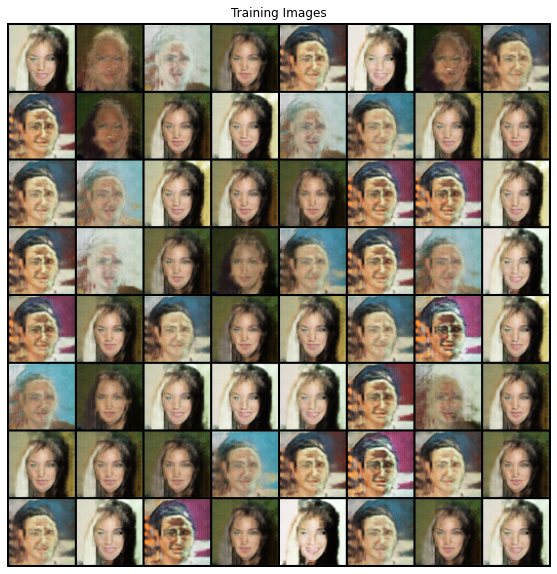

In [ ]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(data[0].cpu()[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def upsample(x):
 m =  nn.Upsample(size=(299,299), mode = 'bilinear')(x)
 return m


In [ ]:
def get_preds(x):
  m = inception_v3_model(x)
  return F.softmax(m)

In [ ]:
#Keeping splits value to 8 for considering all of the data
def predictions(data, splits):
  n_splits = data.size()[0] // splits
  preds = get_preds(upsample(data))
  print(type(preds))
  preds = preds.cpu().detach().numpy()
  return preds




In [ ]:
data[0] = data[0].to(device)

In [ ]:
preds = predictions(data[0], 10)

<class 'torch.Tensor'>


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
preds = preds

In [ ]:
preds

array([[1.61445432e-03, 2.17342444e-04, 1.81398311e-04, ...,
        1.73665816e-04, 5.98055252e-04, 2.66760093e-04],
       [1.03239814e-04, 1.73053835e-04, 1.00219797e-04, ...,
        3.56428463e-05, 2.41785056e-05, 1.14918228e-04],
       [2.04260388e-04, 2.13173887e-04, 3.90152018e-05, ...,
        6.71140733e-05, 1.83358090e-04, 1.44840305e-04],
       ...,
       [3.27877104e-02, 3.23953980e-04, 2.60713423e-04, ...,
        1.17601965e-04, 2.58572312e-04, 9.04200133e-05],
       [4.76640044e-03, 3.77961405e-04, 2.68119096e-04, ...,
        1.43257974e-04, 2.14410611e-04, 4.03045473e-04],
       [1.73881708e-03, 2.17481705e-04, 1.73494176e-04, ...,
        1.82206393e-04, 5.81368047e-04, 2.12249652e-04]], dtype=float32)

In [ ]:
preds.shape

(64, 1000)

In [ ]:
'''
for i in range(8):
  print(preds[i*8:i*8+8])
  '''

'\nfor i in range(8):\n  print(preds[i*8:i*8+8])\n  '

In [ ]:
import math
def get_inception_score(preds, splits):
  part = math.floor(preds.shape[0] / splits)
  
  part_scores = []
  for i in range(splits):
    scores = []
    part = preds[i*splits:i*splits+splits]
    #Getting the average of the p(y|x) over the samples
    p_y = np.mean(part, axis = 0)
    for j in range(part.shape[0]):
      p_y_x = part[i] # GEtting the p(y|x) for each x
      scores.append(entropy(p_y_x, p_y))
    part_scores.append(np.mean(np.exp(scores)))
  return np.mean(part_scores)


In [ ]:
i_d = get_inception_score(preds, 8)

In [ ]:
i_d

1.4304448